1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Text(0, 0.5, 'y')

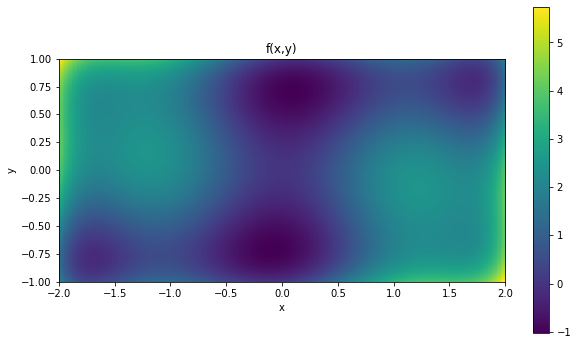

In [6]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
from scipy import optimize

def f(X):
    x,y = X # "decouple" the list
    return (4-2.1*x**2+(x**4)/3)*x**2+x*y+(4*y**2-4)*y**2


x,y = np.linspace(-2,2, 100),np.linspace(-1,1, 100) 

#Meshgrid: X is a list with 2 np.array
X = np.meshgrid(x, y)
grid = -2,2,-1,1

#Plot
fig, _ = plt.subplots(figsize=(10, 6))
pylab.imshow(f(X),cmap=plt.cm.viridis,extent=grid) #other colors hsv
plt.colorbar()
plt.title("f(x,y)")
plt.xlabel("x")
plt.ylabel("y")


In [7]:
#optimize.basinhopping finds the nearest global minimum.
#Since f is odd, if f has a minimum in (a,b), then also (-a,-b) is a minimum. Indeed 
bounds_dict = dict(method="L-BFGS-B", bounds=[(-2.,2.),(-1.,1.)])
minima = [optimize.basinhopping(f, x0=[0.,yi], minimizer_kwargs=bounds_dict)['x'] for yi in [0.5,-0.5] ] 

print("There are %.i global minima, with f=%.3f. They are located in [x,y]:" % (len(minima),f(minima[0])))
print("\n".join(str(p) for p in minima),'\n\n')

print("With optimize.minimize(), if x0=[0.,0.]:\n",optimize.minimize(f, x0=(0,0)),'\n\nSince nit = 0, we may already have in a local minima and the algorithm doesn\'t even start.')
print("However with optimize.basinhopping(), if x0=[0,0] e still get one of the two global minima: ",optimize.basinhopping(f, x0=[0.,0.], minimizer_kwargs=bounds_dict)['x'])


There are 2 global minima, with f=-1.032. They are located in [x,y]:
[-0.08984201  0.7126564 ]
[ 0.08984201 -0.7126564 ] 


With optimize.minimize(), if x0=[0.,0.]:
       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.]) 

Since nit = 0, we may already have in a local minima and the algorithm doesn't even start.
However with optimize.basinhopping(), if x0=[0,0] e still get one of the two global minima:  [ 0.08984201 -0.71265641]


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

FIT TMin
	const = 52.65 +- 1.40
	offset = -61.32 +- 1.19
	mean = 6.16 +- 0.05
	sigma = 1.98 +- 0.08
Covariance Matrix:
 [[ 2.22851223e-03 -4.92594474e-05  1.09110811e-03 -8.73580023e-04]
 [-4.92594474e-05  5.77339458e-03 -7.06539367e-02  2.27202841e-02]
 [ 1.09110811e-03 -7.06539367e-02  1.41334226e+00 -1.05133224e+00]
 [-8.73580023e-04  2.27202841e-02 -1.05133224e+00  1.96937765e+00]]
Chi2: 0.583, p-value:0.999997
FIT TMax
	const = 23.09 +- 1.15
	offset = 15.78 +- 1.18
	mean = 5.74 +- 0.08
	sigma = 2.29 +- 0.17
Covariance Matrix:
 [[ 6.31514499e-03 -2.12235077e-04  1.91650169e-03 -1.60425559e-03]
 [-2.12235077e-04  2.75442667e-02 -1.70936391e-01  1.01481296e-01]
 [ 1.91650169e-03 -1.70936391e-01  1.38434545e+00 -1.08341671e+00]
 [-1.60425559e-03  1.01481296e-01 -1.08341671e+00  1.32868064e+00]]
Chi2: 0.368, p-value:1.000000


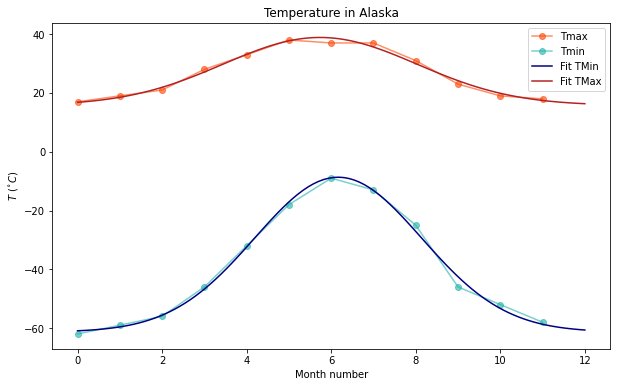

In [38]:
from scipy import stats

tmax = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
tmin = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

#Plotting T
fig, ax  = plt.subplots(figsize=(10, 6))
ax.plot(tmax, c='orangered', marker="o", label="Tmax", alpha=.6)
ax.plot(tmin, c='lightseagreen', marker="o", label="Tmin", alpha=.6)
ax.set_title("Temperature in Alaska")
ax.set_xlabel("Month number")
ax.set_ylabel("$T\ (^{\circ}C)$")

#Model function: A*N(mu, sigma)+offset
def gaussian(x, mu, sigma, c, A):
    return A*np.exp(-(x - mu)**2 / (2 * sigma**2))+c

#pvalue and chi2    
def pvalue(obs,exp,ddof):
    chi2 = np.sum(((obs - exp)**2) / np.abs(obs) )
    pvalue = 1. - stats.chi2.cdf(chi2, 11)
    return [chi2,pvalue]
    

months=np.arange(0,12)
mesh = np.linspace(0,12,100)

for t,c,s in zip([tmin,tmax],['navy','firebrick'],['Min','Max']):
    #Fit and plot
    params, params_covariance = optimize.curve_fit(gaussian, months, t, p0=[7,2,-1, 10], full_output=False)
    ax.plot(mesh, gaussian(mesh, params[0], params[1], params[2], params[3]) ,  c, label = 'Fit T'+s)
    #Printing the results
    print('FIT T'+s)
    print("\tconst = %.2f +- %.2f" % (params[3], np.sqrt(params_covariance[3,3])))
    print("\toffset = %.2f +- %.2f" % (params[2], np.sqrt(params_covariance[2,2])))
    print("\tmean = %.2f +- %.2f" % (params[0], np.sqrt(params_covariance[0,0])))
    print("\tsigma = %.2f +- %.2f" % (params[1], np.sqrt(params_covariance[1,1])))
    print("Covariance Matrix:\n", params_covariance)
    exp = gaussian(months, params[0], params[1], params[2], params[3])
    print("Chi2: {:.3f}, p-value:{:.6f}".format(*pvalue(t,exp,11)))
ax.legend(loc='best')

REMARK: the model is 
$$y = const \cdot N(\mu, \sigma) + offset$$
The pvalue is close to 1 in both cases, so the fit is reasonable.

Moreover by looking at the fit parameters and their errors, we can see that both $\sigma$ and $\mu$ are compatible between the two fit.
So the time offset between min and max temperature is the same in considering the errors

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats

x=pd.read_pickle("data_ex/residuals_261.pkl")
print(x,'\n', type(x))

df = pd.DataFrame(x.item()) #.item method to extract the dict
df = df[abs(df['residuals'])<2] #cleaning the residuals >2, as done in 07ex2 

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])} 
 <class 'numpy.ndarray'>


Text(1.2, 800, 'Entries      10489\nMean          -0.09\nStd Dev       0.23\nConst       608.89\nChi2       1330.48')

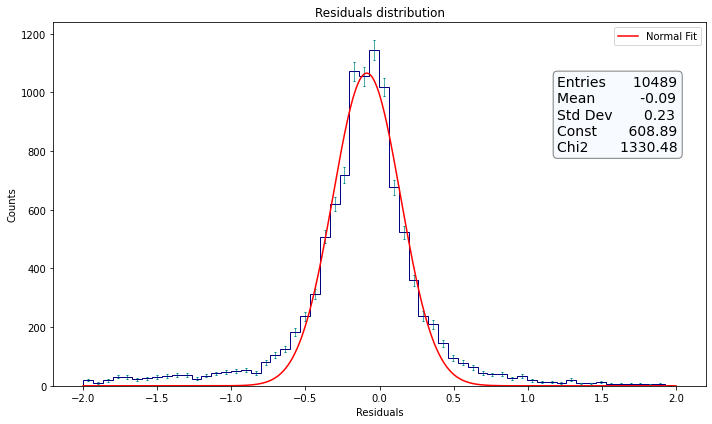

In [47]:
#ROOT-style histogram
fig, ax = plt.subplots(figsize=(10, 6))
h, bins, _ = ax.hist(df['residuals'], bins=60, color='navy',histtype="step")
ax.set_title('Residuals distribution')
ax.set_xlabel("Residuals")
ax.set_ylabel("Counts")
x_bins = bins[:-1]+ 0.5*(bins[1:] - bins[:-1])
ax.errorbar(x_bins, h, yerr=np.sqrt(h), fmt='none', c='darkcyan', linewidth=0.7, capsize=1)
fig.tight_layout()

#Model function: c*N(mu, sigma)
def normal(x, mu, sigma, c):
    return c*stats.norm.pdf(x,mu,sigma)

#pvalue function
def pvalue(obs,exp,ddof):
    chi2 = np.sum(((obs - exp)**2) / np.abs(obs) )
    pvalue = 1. - stats.chi2.cdf(chi2, ddof)
    return [chi2,pvalue]

#Fitting and plotting
mesh=np.linspace(-2,2,1000)
params, params_covariance = optimize.curve_fit(normal, x_bins, h, p0=[0,3, 1000], full_output=False)
ax.plot(mesh, normal(mesh, params[0], params[1], params[2]), c='red', label = 'Normal Fit')
ax.legend(loc='best')

chi2,pvalue = pvalue(h,normal(x_bins, params[0], params[1], params[2]),len(h)-1)

s = '\n'.join((
    'Entries %10i' % len(df),
    "Mean     %10.2f" % params[0],
    "Std Dev %10.2f" % params[1],
    "Const   %10.2f" % params[2],
    "Chi2    %10.2f" % chi2
    ))
ax.text(1.2,800,s, fontsize=14, bbox=dict(boxstyle='round', facecolor='aliceblue', alpha=0.5))

Normal Fit for residuals
	const = 608.89 +- 13.59
	mean = -0.09 +- 0.01
	std dev = 0.23 +- 0.01
Covariance Matrix:
 [[ 3.44996044e-05 -1.94623209e-13  3.30042934e-10]
 [-1.94623209e-13  3.44996045e-05  4.60883018e-02]
 [ 3.30042934e-10  4.60883018e-02  1.84709208e+02]]
Chi2: 1330.483, p-value:0.000000
Since the p-value (left tail) is smaller than the significance level, the fit isn't satisfactory


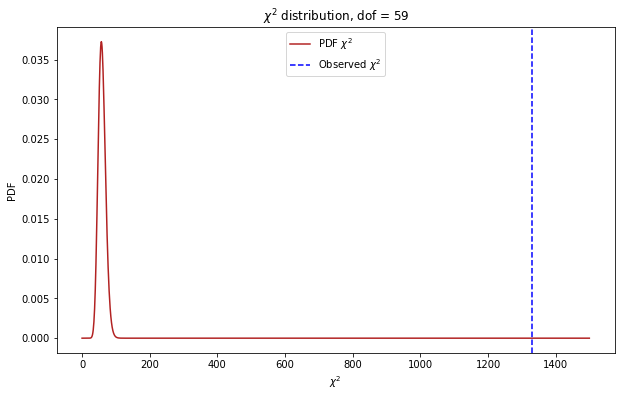

In [60]:
#Printing the results
print("Normal Fit for residuals")
print("\tconst = %.2f +- %.2f" % (params[2], np.sqrt(params_covariance[2,2])))
print("\tmean = %.2f +- %.2f" % (params[0], np.sqrt(params_covariance[0,0])))
print("\tstd dev = %.2f +- %.2f" % (params[1], np.sqrt(params_covariance[1,1])))
print("Covariance Matrix:\n", params_covariance)
print("Chi2: {:.3f}, p-value:{:.6f}".format(chi2,pvalue))
print("Since the p-value (left tail) is smaller than the significance level, the fit isn't satisfactory")
 
#Chi2 distribution plot
fig, _ = plt.subplots(figsize=(10, 6))
plt.plot(p, stats.chi2.pdf(np.arange(0, 1500, 1), df=len(h)-1), c="firebrick", label="PDF $\chi^2$")
plt.axvline(chi2, linestyle='--', color='blue', label="Observed $\chi^2$")  
plt.title('$\chi^2$ distribution, dof = %i'% (len(h)-1))
plt.xlabel("$\chi^2$")
plt.ylabel("PDF")
plt.legend()

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats
import math as m
import inspect

import urllib.request, ssl

ssl._create_default_https_context = ssl._create_unverified_context #In Jupyter notebook, one needs to workaround the certificate

url = "https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt"
with urllib.request.urlopen(url+'?dl=1') as data_file:
    df=pd.read_csv(data_file, sep=' ',names=['D','T'])
    
df = df[(df['D']<2012) & (df['D']>2008) & (df['T']<50)] #Restric to 2008:2012 and clean senseless meaurements

df


,D,T
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


In [11]:
#Model functions
def f(t,*p):
    return p[0]*np.sin(2*m.pi*t+p[1])+p[2]

def g(t,*p):
    return p[0]*np.sin(2*m.pi*p[1]*t+p[2])+p[3]

#pvalue function
def pvalue(obs,exp,ddof):
    chi2 = np.sum(((obs - exp)**2) / np.abs(obs) )
    pvalue = 1. - stats.chi2.cdf(chi2, ddof)
    return [chi2,pvalue]

#Ftest function
def Ftest(ssr_1, ssr_2, ndof_1,ndof_2, N):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(N - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, N - ndof_2)
    return CL,F

#Function to fit and plot: (data_x,data_y,function to fit,name of the function, axes, color fit line, initial parameters)
def fitting_data(x,y,f,name_f,ax,color,p0):
    
    #Fitting
    mesh=np.linspace(min(x),max(x),1000)
    params, params_covariance = optimize.curve_fit(f, x, y, p0=p0, full_output=False)
    testchi2 = pvalue(y,f(x, *params),len(y)-1)
    ssr = np.sum((y-f(x, *params))**2)
    
    #Plotting the function on the (passed) ax
    ax.plot(mesh, f(mesh, *params), c=color, label = "Fit "+name_f)
    
    #Printing the results
    print("Fit function:\n",inspect.getsource(f))
    print("Fit parameters")
    for i in range(len(params)):
        print("\t p%i = %6.2f +- %3.2f" % (i,params[i], np.sqrt(params_covariance[i,i])))
    print("Covariance Matrix:\n", params_covariance)
    print("Chi2: {:.3f}, p-value:{:.6f}\n\n\n".format(*testchi2))

    return params, params_covariance, ssr #saving useful fitting parameters


Fit function:
 def f(t,*p):
    return p[0]*np.sin(2*m.pi*t+p[1])+p[2]

Fit parameters
	 p0 =  -9.96 +- 0.13
	 p1 =   1.34 +- 0.01
	 p2 =   9.26 +- 0.09
Covariance Matrix:
 [[ 1.75558201e-02  9.86142004e-07 -2.76510315e-06]
 [ 9.86142004e-07  1.77325793e-04  5.40545929e-08]
 [-2.76510315e-06  5.40545929e-08  8.78853325e-03]]
Chi2: 4348.050, p-value:0.000000



Fit function:
 def g(t,*p):
    return p[0]*np.sin(2*m.pi*p[1]*t+p[2])+p[3]

Fit parameters
	 p0 =  -9.96 +- 0.13
	 p1 =   1.00 +- 0.00
	 p2 =  -2.37 +- 23.79
	 p3 =   9.27 +- 0.10
Covariance Matrix:
 [[ 1.77594794e-02 -2.63995626e-05  3.33414968e-01 -2.64357533e-04]
 [-2.63995626e-05  3.54853507e-06 -4.48162862e-02  3.44887365e-05]
 [ 3.33414967e-01 -4.48162862e-02  5.66008254e+02 -4.35575932e-01]
 [-2.64357532e-04  3.44887365e-05 -4.35575932e-01  9.12964123e-03]]
Chi2: 4343.038, p-value:0.000000





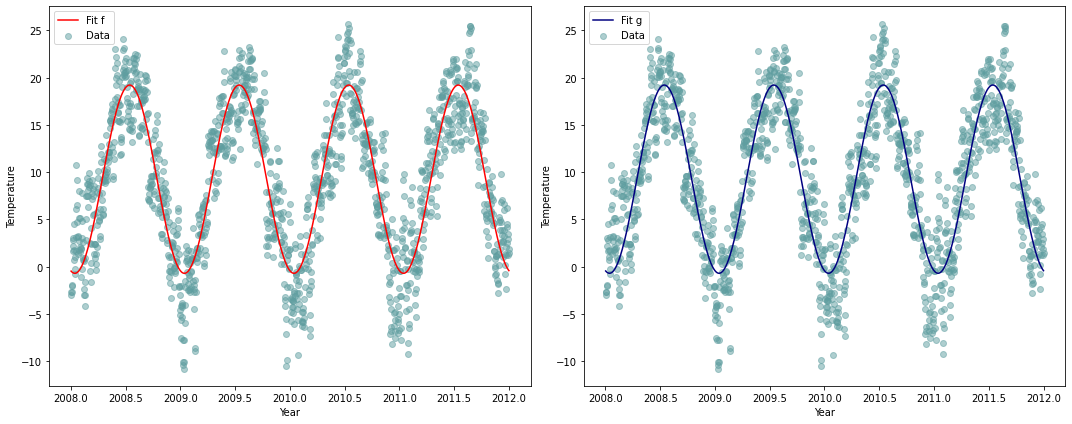

In [12]:
fig, ax = plt.subplots(ncols=2,figsize=(15, 6))
for i in range(2):
    ax[i].scatter(df['D'], df['T'], marker='o',c='cadetblue', alpha=.5, label="Data")
    ax[i].set_ylabel("Temperature")
    ax[i].set_xlabel("Year")

p_f, _, ssr_f = fitting_data(df['D'], df['T'],f,"f",ax[0],"red",[10,1,10])
p_g, _, ssr_g = fitting_data(df['D'], df['T'],g,"g",ax[1],"navy",[10,1,1,10])

#NOTE: it seems there are a lot of local minima for each choice of initial value of parameter b (in curve_fit for g).

ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.tight_layout()


In [45]:
#Average temperature and max min temperature
print("The overall average temperature in Munich in 2008-2012 was %.2f degrees" %(np.mean(df['T'])) )

Tmin = optimize.minimize_scalar(f, args=(*p_f,) ,method='bounded', bounds=[2008, 2012])['fun'] 
Tmax = - optimize.minimize_scalar(lambda x:-f(x,*p_f),method='bounded', bounds=[2008, 2012])['fun']  
print("Maximum and minimium temperature predicted by the model during the year are: %.2f - %.2f" %(Tmin,Tmax))
print("Parameter b (in our case p1=%.3f) is the x-offset with respect a sin(x) function. From a physical point of view, having b~1.3 means that the coldest period in the year comes some days after New Year's Day." %(p_f[1]))

print("SSR for f = %.3f\nSSR for g = %.3f"%(ssr_f,ssr_g) )
CL,F = Ftest(ssr_f,ssr_g,1,2, len(df)) #since we are adding just 1 parameter more
print("Fisher Test: CL = %.3f" % CL, ", additional parameter necessary:", "YES, take the new function g" if CL < 0.10 else "NO, keep f")


The overall average temperature in Munich in 2008-2012 was 9.26 degrees
Maximum and minimium temperature predicted by the model during the year are: -0.70 - 19.22
Parameter b (in our case p1=1.336) is the x-offset with respect a sin(x) function. From a physical point of view, having b~1.3 means that the coldest period in the year comes some days after New Year's Day.
SSR for f = 18669.515
SSR for g = 18669.225
Fisher Test: CL = 0.880 , additional parameter necessary: NO, keep f
